In [1]:
import pandas as pd
import numpy as np
import os
import sys
import datetime
import time

#from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler,Normalizer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, r2_score
from sklearn.feature_selection import mutual_info_regression

import matplotlib.dates as mdates
import matplotlib.colors
import matplotlib.ticker as ticker

import pytz
import shap
import pickle

from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection

RANDOM_STATE = 42

# Perameters


In [2]:
cheap_node_list = ['001e063059c2', '001e06305a61', '001e06305a6c', '001e06318cd1',
                   '001e06323a05', '001e06305a57', '001e06305a6b', '001e06318c28',
                   '001e063239e3', '001e06323a12']

cheap_node_id = '001e06305a6b'
node_id = '10004098'
gps_node_id = '001e0610c2e9'
dir_out = '../figures/' + cheap_node_id + '/'
dir_data = '../data/'

years = ['2019','2020'] ####
months = ['1','2','3','4','5','6','7','8','9','10','11','12']
days = np.array(range(1,31+1)).astype(str) #### np.array(range(1,31+1)).astype(str)
days = list(days)

hours = (np.array(range(0,24))).astype(str)
hours = list(hours)

bins = np.array(range(0,420+1)).astype(str)
bins = list(bins)
for i in range(len(bins)):
    bins[i] = 'Spectrum[' + bins[i] + ']'

wavelengths = np.array(range(360,780+1))#.astype(str)
#for i in range(len(wavelengths)):
#    wavelengths[i] = wavelengths[i] + 'nm'
#wavelengths = list(wavelengths)

## Read Data

In [3]:
# if data has been preprocessed before, run this directly
fn_data = dir_data + node_id + '_'+ cheap_node_id +'.csv'
df = pd.read_csv(fn_data, parse_dates=True, index_col = 'UTC')
df = df[(df.index.date != datetime.date(2019, 12, 31)) # Minolta was covered in these dates
       &(df.index.date != datetime.date(2019, 12, 27))
       &(df.index.date != datetime.date(2020,  1,  1))
       &(df.index.date != datetime.date(2020,  1,  2))]
#        &(df.index.date != datetime.date(2020, 2, 14))
#        &(df.index.date != datetime.date(2020, 2, 21))]

In [14]:
df.tail()

,cloudPecentage,allRed,allGreen,allBlue,skyRed,skyGreen,skyBlue,cloudRed,cloudGreen,cloudBlue,...,773nm,774nm,775nm,776nm,777nm,778nm,779nm,780nm,Zenith,Azimuth
UTC,,,,,,,,,,,,,,,,,,,,,
2020-04-20 14:40:10,99.873210,154.595033,132.282885,148.242455,8.399598,9.232905,3.505365,154.780654,132.439107,148.426197,...,0.063565,0.064274,0.064647,0.064779,0.064925,0.065031,0.065023,0.064903,55.560242,98.587030
2020-04-20 14:40:20,99.871419,154.704438,132.358394,148.272821,8.390341,9.267894,3.557604,154.892855,132.516884,148.459129,...,0.064443,0.065189,0.065597,0.065756,0.065893,0.065967,0.065923,0.065770,55.525661,98.613268
2020-04-20 14:40:30,99.869629,154.813843,132.433903,148.303186,8.381085,9.302882,3.609844,155.005057,132.594661,148.492061,...,0.065093,0.065842,0.066252,0.066417,0.066595,0.066725,0.066731,0.066611,55.491082,98.639522
2020-04-20 14:40:40,99.867839,154.923248,132.509412,148.333551,8.371829,9.337870,3.662083,155.117258,132.672437,148.524993,...,0.066125,0.066894,0.067316,0.067481,0.067635,0.067729,0.067700,0.067554,55.456506,98.665791
2020-04-20 14:40:50,99.866048,155.032652,132.584921,148.363917,8.362572,9.372859,3.714323,155.229459,132.750214,148.557925,...,0.082538,0.083594,0.084193,0.084425,0.084440,0.084272,0.083945,0.083514,55.421932,98.692076


In [4]:
features = [#'cloudPecentage', 'allRed', 'allGreen', 'allBlue',
            #'skyRed', 'skyGreen', 'skyBlue', 'cloudRed', 'cloudGreen', 'cloudBlue',
            'Violet', 'Blue', 'Green', 'Yellow', 'Orange', 'Red',
#             'Temperature', 'Pressure', 'Humidity',
            #'Latitude', 'Longitude', 'Altitude',
            #'NH3', 'CO', 'NO2', 'C3H8', 'C4H10', 'CH4', 'H2', 'C2H5OH', 'CO2',
            # 'Luminosity', # it is IR in another unit
            'IR', # Infrared
            # 'Full', # Full = IR + Visible
            'Visible', 'Lux',
            'UVA', 'UVB', 'Visible Compensation','IR Compensation', 'UV Index']#,
#             'Zenith','Azimuth']
features = np.array(features)
num_features = len(features)
print(num_features)

wavelengths = np.array(range(360,780+1))
targets =np.array([str(wavelength) + 'nm' for wavelength in wavelengths]) # skip Illuminance, keep Wavelengths
print(features)
print(targets[[0,-1]])

X = df[features]
Y = df[targets] # MLP and scaler use multi output

14
['Violet' 'Blue' 'Green' 'Yellow' 'Orange' 'Red' 'IR' 'Visible' 'Lux'
 'UVA' 'UVB' 'Visible Compensation' 'IR Compensation' 'UV Index']
['360nm' '780nm']


## Prepare Data  For Training

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# scale the data
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

scaler_y = StandardScaler()
Y_train_scaled = scaler_y.fit_transform(Y_train)
Y_test_scaled = scaler_y.transform(Y_test)


In [134]:
# try PCA
pca1 = PCA(n_components=len(features), random_state = RANDOM_STATE)
X_temp = pca1.fit_transform(X_train_scaled[:,:])
print(pca1.explained_variance_)

[1.12034515e+01 1.27679667e+00 6.71244075e-01 4.67584657e-01
 2.48897146e-01 1.10435009e-01 1.83193841e-02 2.75098851e-03
 3.57492967e-04 1.36341343e-04 5.73211069e-05 8.70038584e-06
 6.63963309e-06 4.70403802e-06]


In [135]:
# PCA
n_components = num_features

DR = 'PCA'
Cluster = 'None'
pca = PCA(n_components=n_components, random_state = RANDOM_STATE)

X_train_scaled_DR = pca.fit_transform(X_train_scaled)
X_test_scaled_DR = pca.transform(X_test_scaled)

X_train_scaled_DR = pd.DataFrame(X_train_scaled_DR)
X_test_scaled_DR = pd.DataFrame(X_test_scaled_DR)
print(pca.explained_variance_)

# save pca model
dir_DR = '../models/' + cheap_node_id + '/'
if not os.path.exists(dir_DR):
    os.mkdir(dir_DR)

fn_DR = dir_DR + DR + '.sav'
pickle.dump(pca, open(fn_DR, 'wb'))

[1.12034515e+01 1.27679667e+00 6.71244075e-01 4.67584657e-01
 2.48897146e-01 1.10435009e-01 1.83193841e-02 2.75098851e-03
 3.57492967e-04 1.36341343e-04 5.73211069e-05 8.70038584e-06
 6.63963309e-06 4.70403802e-06]


In [136]:
# scale the data again before NN
scaler_x2 = StandardScaler()
X_train_scaled_DR_scaled = scaler_x2.fit_transform(X_train_scaled_DR)
X_test_scaled_DR_scaled = scaler_x2.transform(X_test_scaled_DR)

# Model Start from here

## Model for Whole Spectrum

In [137]:
hidden_layer_sizes=(64,128,256)

activation ='relu'
solver = 'adam'
alpha=1e-5 # L2 penalty (regularization term) parameter, default 1e-5
learning_rate = 'constant'
early_stopping = True
tol = 1e-4
n_iter_no_change = 10


# include layer structure and activation function
if type(hidden_layer_sizes) == int: # single-layer case
    hidden_layer_sizes_string = str(hidden_layer_sizes)
else: # multi-layers case
    hidden_layer_sizes_string = str(hidden_layer_sizes)[1:-1].replace(', ','_')
    
structure = '_' + DR + str(n_components) + \
            '_' + hidden_layer_sizes_string + \
            '_' + activation

In [29]:
start_time = time.time()

regr = MLPRegressor(random_state = RANDOM_STATE,
                    hidden_layer_sizes = hidden_layer_sizes,
                    activation = activation,
                    solver = solver,
                    alpha = alpha,
                    learning_rate = learning_rate,
                    verbose = True,
                    early_stopping = early_stopping,
                    tol = tol,
                    n_iter_no_change = n_iter_no_change
                    )
regr.fit(X_train_scaled_DR_scaled, Y_train_scaled)

print("--- %s seconds ---" % (time.time() - start_time))

Iteration 1, loss = 0.01489357
Validation score: 0.992592
Iteration 2, loss = 0.00329837
Validation score: 0.993900
Iteration 3, loss = 0.00274868
Validation score: 0.994616
Iteration 4, loss = 0.00251549
Validation score: 0.994771
Iteration 5, loss = 0.00240066
Validation score: 0.995463
Iteration 6, loss = 0.00218650
Validation score: 0.995670
Iteration 7, loss = 0.00203253
Validation score: 0.995656
Iteration 8, loss = 0.00190637
Validation score: 0.995610
Iteration 9, loss = 0.00185818
Validation score: 0.996163
Iteration 10, loss = 0.00175169
Validation score: 0.996241
Iteration 11, loss = 0.00170045
Validation score: 0.996556
Iteration 12, loss = 0.00164936
Validation score: 0.996464
Iteration 13, loss = 0.00158331
Validation score: 0.996875
Iteration 14, loss = 0.00155799
Validation score: 0.996932
Iteration 15, loss = 0.00150018
Validation score: 0.996902
Iteration 16, loss = 0.00147703
Validation score: 0.997126
Iteration 17, loss = 0.00142925
Validation score: 0.996984
Iterat

In [30]:
# save model
dir_model = '../models/' + cheap_node_id + '/'
if not os.path.exists(dir_model):
    os.mkdir(dir_model)
dir_model += 'whole/'
if not os.path.exists(dir_model):
    os.mkdir(dir_model)

fn_model = dir_model + 'MLP_whole' + structure + '_1.sav'
pickle.dump(regr, open(fn_model, 'wb'))


In [31]:
regr.warm_start = True
regr.learning_rate_init /= 10 # default 0.001
regr.fit(X_train_scaled_DR_scaled, Y_train_scaled)


Iteration 41, loss = 0.00081192
Validation score: 0.998663
Iteration 42, loss = 0.00077168
Validation score: 0.998691
Iteration 43, loss = 0.00076009
Validation score: 0.998714
Iteration 44, loss = 0.00075109
Validation score: 0.998689
Iteration 45, loss = 0.00074572
Validation score: 0.998676
Iteration 46, loss = 0.00074054
Validation score: 0.998710
Iteration 47, loss = 0.00073642
Validation score: 0.998693
Iteration 48, loss = 0.00073156
Validation score: 0.998708
Iteration 49, loss = 0.00072761
Validation score: 0.998708
Iteration 50, loss = 0.00072380
Validation score: 0.998704
Iteration 51, loss = 0.00071955
Validation score: 0.998713
Iteration 52, loss = 0.00071803
Validation score: 0.998708
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPRegressor(alpha=1e-05, early_stopping=True,
             hidden_layer_sizes=(64, 128, 256), learning_rate_init=0.0001,
             random_state=42, verbose=True, warm_start=True)

In [32]:
# save model
dir_model = '../models/' + cheap_node_id + '/'
if not os.path.exists(dir_model):
    os.mkdir(dir_model)
dir_model += 'whole/'
if not os.path.exists(dir_model):
    os.mkdir(dir_model)

fn_model = dir_model + 'MLP_whole' + structure + '_2.sav'
pickle.dump(regr, open(fn_model, 'wb'))


In [138]:
# load model
dir_model = '../models/' + cheap_node_id + '/'  + 'whole/'
fn_model = dir_model + 'MLP_whole' + structure + '_2.sav'
regr = pickle.load(open(fn_model, 'rb'))


In [44]:
structure

'_PCA14_64_128_256_relu'

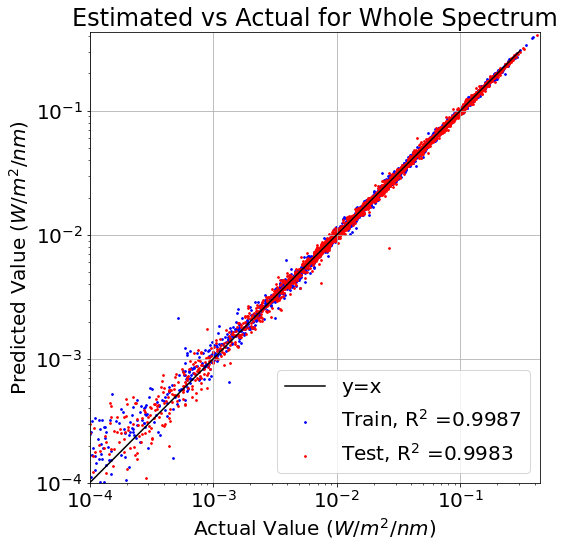

In [141]:
from sklearn.metrics import r2_score

Y_train_pred = scaler_y.inverse_transform(
                    regr.predict( X_train_scaled_DR_scaled )
                    ) # for train
# Y_train_pred = regr.predict( X_train_scaled_DR_scaled ) # for train
train_score = r2_score(Y_train, Y_train_pred)

Y_test_pred = scaler_y.inverse_transform(
                    regr.predict( X_test_scaled_DR_scaled )
                    )# for test
# Y_test_pred = regr.predict( X_test_scaled_DR_scaled )# for test
test_score = r2_score(Y_test, Y_test_pred)

# flatten
Y_train_flatten = Y_train.values.flatten()
Y_train_pred_flatten = Y_train_pred.flatten()

Y_test_flatten = Y_test.values.flatten()
Y_test_pred_flatten = Y_test_pred.flatten()

Y_min = 0 # np.min(Y_train_flatten)
Y_max = np.mean(Y_train_flatten) + 5*np.std(Y_train_flatten)

y_line = np.linspace(Y_min,Y_max,100)

plt.rcParams["figure.figsize"] = (8, 8) # (w, h)
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots()
plt.plot(y_line,y_line, '-k', label='y=x')

id_train = np.random.choice(len(Y_train_flatten), 5000, replace = False)
plt.scatter(Y_train_flatten[id_train], Y_train_pred_flatten[id_train], s=3, c = 'blue',label = 'Train, R$^{2}$ ='+str(train_score)[:6])

id_test = np.random.choice(len(Y_test_flatten), 5000, replace = False)
plt.scatter(Y_test_flatten[id_test], Y_test_pred_flatten[id_test], s=3, c = 'red', label = 'Test, R$^{2}$ ='+str(test_score)[:6])

plt.xlim(10E-5, )
plt.ylim(10E-5, )

ax.set_title('Estimated vs Actual for Whole Spectrum')
ax.set_xlabel('Actual Value $(W/m^2/nm)$')
ax.set_ylabel('Predicted Value $(W/m^2/nm)$')
plt.xscale('log')
plt.yscale('log')
plt.legend( loc='lower right')
plt.grid()
plt.tight_layout()

if not os.path.exists(dir_out + 'whole'):
    os.mkdir(dir_out + 'whole')
plt.savefig(dir_out + 'whole' +'/MLP_performance_whole'+structure+'.png')


In [142]:
Y_train_flatten_sorted = np.sort(Y_train_flatten)
Y_train_pred_flatten_sorted = np.sort(Y_train_pred_flatten)

Y_test_flatten_sorted = np.sort(Y_test_flatten)
Y_test_pred_flatten_sorted = np.sort(Y_test_pred_flatten)

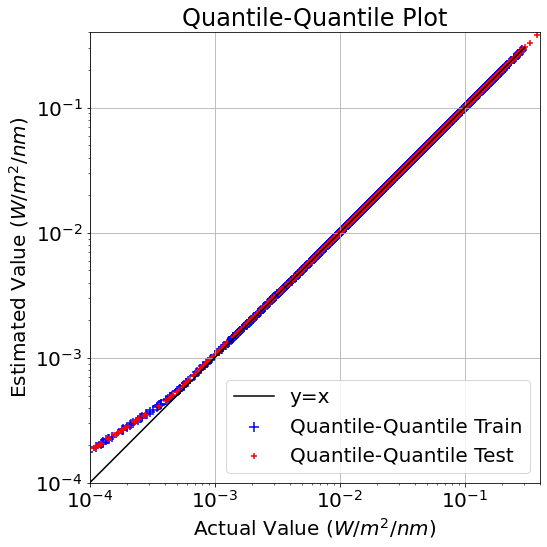

In [143]:
Y_min = 0 # np.min(Y_train_flatten)
Y_max = np.mean(Y_train_flatten) + 5*np.std(Y_train_flatten)
y_line = np.linspace(Y_min,Y_max,100)


plt.rcParams["figure.figsize"] = (8, 8) # (w, h)
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots()
plt.plot(y_line,y_line, '-k', label='y=x')

id_train = np.random.choice(len(Y_train_flatten_sorted), 2000, replace = False)
plt.scatter(Y_train_flatten_sorted[id_train], Y_train_pred_flatten_sorted[id_train], s=100, c = 'blue',
            marker = '+', label = 'Quantile-Quantile Train')

id_test = np.random.choice(len(Y_test_flatten_sorted), 2000, replace = False)
plt.scatter(Y_test_flatten_sorted[id_test], Y_test_pred_flatten_sorted[id_test], s=30, c = 'red',
            marker = '+', label = 'Quantile-Quantile Test')
plt.xlim(10E-5, )
plt.ylim(10E-5, )

# x_25 = Y_test_flatten_sorted[Y_test_flatten_sorted.size//4]
# y_25 = Y_test_pred_flatten_sorted[Y_test_pred_flatten_sorted.size//4]
# x_50 = Y_test_flatten_sorted[Y_test_flatten_sorted.size//2]
# y_50 = Y_test_pred_flatten_sorted[Y_test_pred_flatten_sorted.size//2]
# x_75 = Y_test_flatten_sorted[Y_test_flatten_sorted.size//4*3]
# y_75 = Y_test_pred_flatten_sorted[Y_test_pred_flatten_sorted.size//4*3]
# plt.text(x_25, y_25, '25', c ='blue', ha = 'center', va = 'center')
# plt.text(x_50, y_50, '50', c ='blue', ha = 'center', va = 'center')
# plt.text(x_75, y_75, '75', c ='blue', ha = 'center', va = 'center')

ax.set_title('Quantile-Quantile Plot')
ax.set_xlabel('Actual Value $(W/m^2/nm)$')
ax.set_ylabel('Estimated Value $(W/m^2/nm)$')

plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend( loc='lower right')

plt.tight_layout()

if not os.path.exists(dir_out + 'whole'):
    os.mkdir(dir_out + 'whole')
plt.savefig(dir_out + 'whole' +'/MLP_QQ_whole'+structure+'.png')


In [212]:
# bads = {}
# bads_var = {}
# counts = []
# for i in range(len(targets)):
#     var = targets[i]
#     temp = Y_train[var][ (Y_train[var]/Y_train_pred[:,i] > 1.2 ) & (Y_train[var]>0.05)]
#     # count bad dates
#     for date in temp.index.date:
#         if date in bads:
#             bads[date] += 1
#         else:
#             bads[date] = 1
#     # count bad wavelengths
#     var_i = int(var[:-2])
    
#     bads_var[var_i] = len(temp)
#     counts.append(len(temp))
        

# display(bads)

# plt.plot(wavelengths, counts)


In [49]:
train_scores = []
test_scores = []
for i in range(len(wavelengths)):
    train_scores.append( r2_score(Y_train.iloc[:,i], Y_train_pred[:,i]) )
    test_scores.append( r2_score(Y_test.iloc[:,i], Y_test_pred[:,i]) )


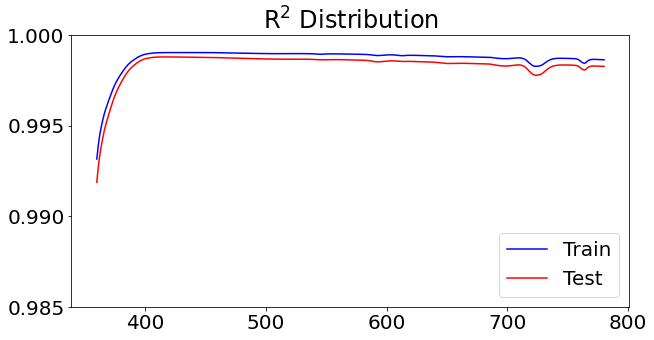

In [50]:
plt.rcParams["figure.figsize"] = (10, 5) # (w, h)
plt.plot(np.array(range(360,780+1)),train_scores, 'b', label = 'Train')
plt.plot(np.array(range(360,780+1)),test_scores, 'r', label = 'Test')
plt.ylim(0.985,1)
plt.title("R$^2$ Distribution")
plt.legend( loc='lower right')
plt.savefig(dir_out + 'whole' + '/MLP_R2' + structure + '.png')


In [51]:
# Create object that can calculate shap values
num_shap = 200
explainer = shap.KernelExplainer(regr.predict, X_train_scaled_DR_scaled[:num_shap])
# Calculate shap_values
shap_values_multi_DR_Yscaled = explainer.shap_values(X_train_scaled_DR_scaled[:num_shap]) # 421 x num_shap x n_components


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/200 [00:00<?, ?it/s]

In [52]:
# inverse transformation of y's scaler
shap_values_multi_DR = np.swapaxes(shap_values_multi_DR_Yscaled, 0, 1) # num_shap x 421 x n_components
for i in range(n_components):
    shap_values_multi_DR[:,:,i] = shap_values_multi_DR[:,:,i] * scaler_y.scale_

shap_values_multi_DR = np.swapaxes(shap_values_multi_DR, 0, 1)

# SHAP values averaged on different wavelengths
shap_values_DR = np.mean(shap_values_multi_DR, axis = 0) # num_shap x n_components

# scaled SHAP values averaged on different wavelengths
shap_values_DR_Yscaled = np.mean(shap_values_multi_DR_Yscaled, axis = 0)

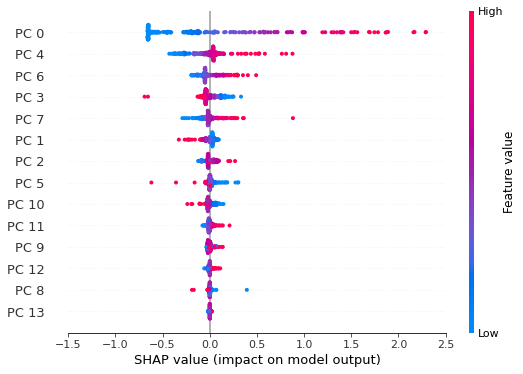

In [55]:
# plot
max_display = num_features
# shap_values = pca.inverse_transform(shap_values_DR)
shap.summary_plot(shap_values_DR_Yscaled, X_train_scaled_DR_scaled[:num_shap],
                  feature_names = ['PC ' + str(i) for i in range(num_features)],
                  plot_size=(8,max_display/2.5),#'auto'
                  max_display = max_display,
                  show=False
                 )
plt.tight_layout()
plt.xlim(-1.5, 2.5)
plt.savefig(dir_out + 'whole' + '/MLP_shapPCA_'+ 'whole' +structure+'.png')

In [56]:
import matplotlib as mpl
import matplotlib.cm as cm

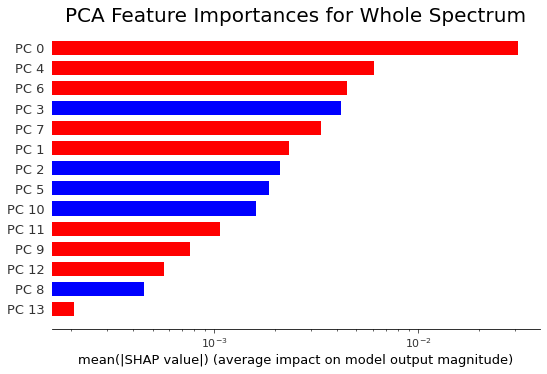

In [57]:
importances_DR = np.mean(np.abs(shap_values_DR_Yscaled), axis = 0)
indices = np.argsort(importances_DR)

# color positive/negative impact blue/red
colormap = {1:'red',-1:'blue', 0:'grey'}
impacts = np.array([])
corrcoef = np.array([])
sign = np.array([])
for i in range(n_components):
    impact_i = (shap_values_DR[:,i]*np.sign(X_train_scaled_DR_scaled[:num_shap,i] - X_train_scaled_DR_scaled[:num_shap, i].mean() )).mean()
    impacts = np.append(impacts, impact_i)
    
    corrcoef_i = np.corrcoef(X_train_scaled_DR_scaled[:,i], Y_train_pred.mean(axis = 1))[0,1]
    corrcoef = np.append(corrcoef, corrcoef_i)
    
    sign_i = np.sign(corrcoef_i)
    sign = np.append(sign, sign_i)

sign = sign[indices]
impacts = impacts[indices]
corrcoef = corrcoef[indices]

# norm = mpl.colors.SymLogNorm(10, vmin=0, vmax=+0.05)
norm = mpl.colors.Normalize(vmin=-1, vmax=+1)
cmap = cm.get_cmap('RdBu_r')
m = cm.ScalarMappable(norm=norm, cmap=cmap)

color = [colormap[val] for val in sign]
# color = [m.to_rgba(val) for val in impacts]
# color = [m.to_rgba(val) for val in corrcoef]

shap.summary_plot(shap_values_DR, X_train_scaled_DR_scaled[:num_shap],
                  feature_names = ['PC ' + str(i) for i in range(num_features)],
                  plot_size=(8,max_display/2.5),#'auto'
                  color = color,
                  max_display = max_display,
                  show = False,
                  plot_type = 'bar'
                 )

plt.xscale("log")
plt.title(DR + ' Feature Importances for Whole Spectrum', fontsize = 20)
plt.tight_layout()
plt.savefig(dir_out + 'whole' + '/MLP_'+DR+'Importances_' + 'whole' + structure +'.png')

In [58]:
X_train_scaled_DR[:num_shap]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.308681,0.479231,-1.034788,0.000253,-0.194624,-0.091369,0.175429,-0.028822,-0.002868,-0.014091,0.001183,-0.001427,0.006239,-0.000194
1,0.500122,-0.363041,-0.232785,-0.304590,-0.879899,0.164489,-0.094336,0.022329,-0.001624,-0.009580,-0.009217,0.002371,0.000794,0.004048
2,-1.970780,4.037768,1.863530,-0.354578,-0.066930,-0.168909,0.137069,-0.016508,0.002078,0.004780,0.007071,0.002747,-0.001406,0.001039
3,10.602797,0.322022,0.356590,0.008735,1.405033,-0.367322,-0.155355,-0.074559,0.004038,-0.022114,-0.014254,-0.001122,0.004244,-0.003911
4,-2.646921,-1.032917,0.351382,0.084054,0.273400,-0.030896,0.007994,0.000173,-0.000175,-0.000837,-0.000037,0.000087,-0.000116,-0.000066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,-2.646976,-1.032370,0.351624,0.084002,0.273380,-0.030876,0.007991,0.000174,-0.000176,-0.000838,-0.000038,0.000087,-0.000116,-0.000066
196,1.279336,-0.613775,0.003906,-0.617432,-0.973048,0.168806,0.061883,-0.028284,0.000764,0.012086,0.007305,0.003388,0.003539,-0.002212
197,-2.647013,-1.031898,0.351785,0.083958,0.273335,-0.030847,0.007981,0.000176,-0.000176,-0.000839,-0.000040,0.000086,-0.000116,-0.000066
198,-0.361678,0.149868,-0.717478,-0.048802,-0.470376,0.192760,-0.190084,0.046316,-0.003594,-0.012755,-0.002270,-0.000878,0.000457,-0.002762


In [59]:
np.matmul(X_train_scaled[:num_shap], pca.components_.T)

array([[-3.08680910e-01,  4.79230946e-01, -1.03478811e+00, ...,
        -1.42705595e-03,  6.23879967e-03, -1.93749763e-04],
       [ 5.00121968e-01, -3.63041410e-01, -2.32784604e-01, ...,
         2.37080702e-03,  7.93511347e-04,  4.04803017e-03],
       [-1.97078027e+00,  4.03776811e+00,  1.86352958e+00, ...,
         2.74705048e-03, -1.40550013e-03,  1.03884966e-03],
       ...,
       [-2.64701310e+00, -1.03189824e+00,  3.51784825e-01, ...,
         8.64206971e-05, -1.15685474e-04, -6.58665979e-05],
       [-3.61677623e-01,  1.49867796e-01, -7.17478195e-01, ...,
        -8.77805694e-04,  4.56540910e-04, -2.76236360e-03],
       [ 2.17117781e+00, -4.99825071e-01,  1.81763466e-02, ...,
        -5.79760670e-04,  1.92963489e-04, -3.26611281e-03]])

In [92]:
# linearly split the PCA SHAP values into original features
shap_values = np.zeros((num_shap, num_features))

X_train_scaled0 = np.matmul(X_train_scaled_DR[:num_shap], pca.components_).values  # PCA inverse transformation
X_train_scaled0_mean = X_train_scaled0[:num_shap].mean(axis = 0)
for i in range(num_shap):
    linear_shap = pca.components_*(X_train_scaled0[i] - X_train_scaled0_mean) # n_components x n_features
    
    i_start = 0
    num_pca = 1 # n_components 
    linear_shap_ratio = linear_shap[i_start:i_start+num_pca] / linear_shap[i_start:i_start+num_pca].sum(axis = 1)[:,None] # n_components x n_features 
    shap_values[i,:] = np.matmul(shap_values_DR_Yscaled[i,i_start:i_start+num_pca], linear_shap_ratio)
    

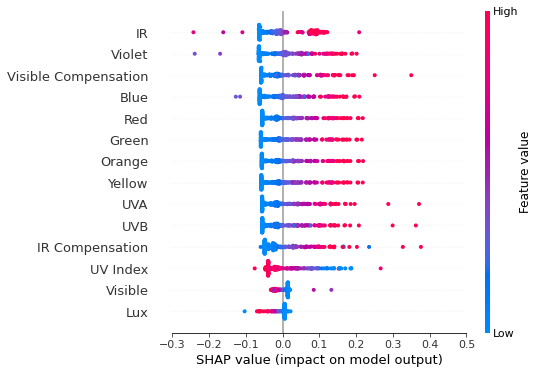

In [93]:
# plot
max_display = num_features

shap.summary_plot(shap_values, X_train[:num_shap],
                  feature_names = features,
                  plot_size=(8,max_display/2.5),#'auto'
                  max_display = max_display,
                  show=False
                 )
plt.xlim(-0.3,0.5)
plt.tight_layout()
plt.savefig(dir_out + 'whole' + '/MLP_shap_'+ 'whole' +structure+'.png')

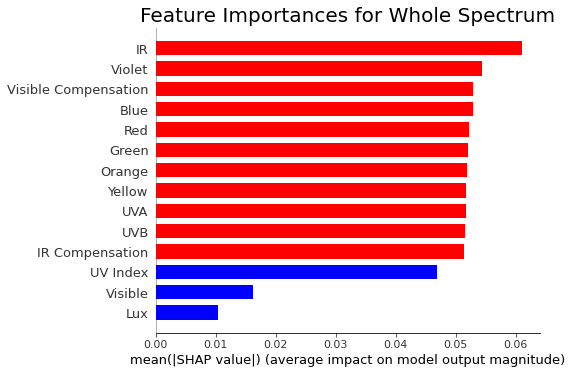

In [94]:
importances = np.mean(np.abs(shap_values), axis = 0)
indices = np.argsort(importances)

# color positive/negative impact blue/red
colormap = {1:'red',-1:'blue', 0:'grey'}
impact = np.array([])
corrcoef = np.array([])
sign = np.array([])
for i in range(num_features):
    impact_i = (shap_values[:,i]*np.sign(X_train.values[:num_shap,i] - X_train.values[:num_shap, i].mean() )).mean()
    impacts = np.append(impacts, impact_i)
    
    corrcoef_i = np.corrcoef(X_train.values[:,i], Y_train_pred.mean(axis = 1))[0,1]
    corrcoef = np.append(corrcoef, corrcoef_i)
    
    sign_i = np.sign(corrcoef_i)
    sign = np.append(sign, sign_i)

sign = sign[indices]
impacts = impacts[indices]
corrcoef = corrcoef[indices]

# norm = mpl.colors.SymLogNorm(10, vmin=0, vmax=+0.05)
norm = mpl.colors.Normalize(vmin=-1, vmax=+1)
cmap = cm.get_cmap('RdBu_r')
m = cm.ScalarMappable(norm=norm, cmap=cmap)

color = [colormap[val] for val in sign]
# color = [m.to_rgba(val) for val in impacts]
# color = [m.to_rgba(val) for val in corrcoef]

shap.summary_plot(shap_values, X_train[:num_shap],
                  feature_names = features,
                  plot_size=(8,max_display/2.5),#'auto'
                  color = color,
                  max_display = max_display,
                  show = False,
                  plot_type = 'bar'
                 )

# plt.xscale("log")
plt.title('Feature Importances for Whole Spectrum', fontsize = 20)
plt.tight_layout()
plt.savefig(dir_out + 'whole' + '/MLP_Importances_' + 'whole' + structure +'.png')

In [95]:
id_train = X_train.index
id_test = X_test.index

Zenith_train = df.loc[id_train, 'Zenith']
Zenith_test = df.loc[id_test, 'Zenith']

Azimuth_train = df.loc[id_train, 'Azimuth']
Azimuth_test = df.loc[id_test, 'Azimuth']


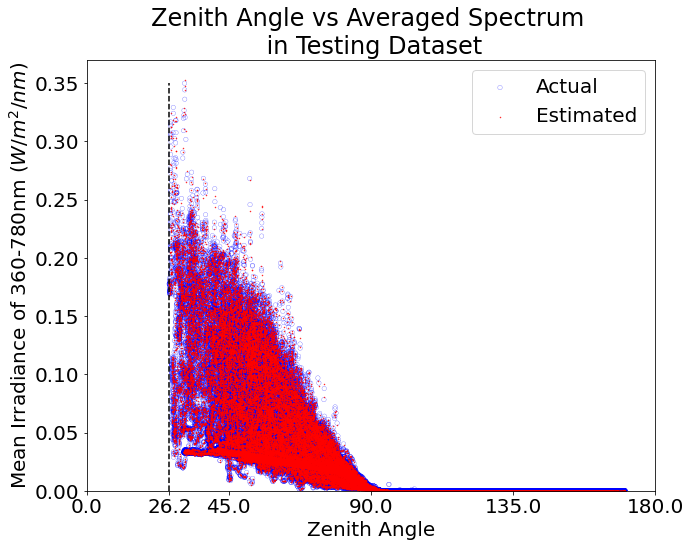

In [96]:
plt.rcParams["figure.figsize"] = (10, 8) # (w, h)
plt.rcParams.update({'font.size': 20})
colors = 'black' #pca.transform(scaler_x.transform(X))[:,0]

y_min = Y_test.mean(axis = 1).min()
y_max = Y_test.mean(axis = 1).max()
Zenith_min = Zenith_test.min()

plt.scatter(Zenith_test, Y_test.mean(axis = 1), 
            marker = 'o', facecolors='none', edgecolors='blue', linewidths=0.2, s = 20,
            label = 'Actual')
plt.scatter(Zenith_test, Y_test_pred.mean(axis = 1), 
            marker = 'o', color = 'red', s = 0.2,
            label = 'Estimated')

plt.plot([Zenith_min, Zenith_min], [y_min, y_max], '--', c = 'black')

plt.xticks(list(np.linspace(0,180,5))+[Zenith_min]);
plt.xlabel('Zenith Angle');
plt.ylabel('Mean Irradiance of 360-780nm $(W/m^2/nm)$');
plt.title('Zenith Angle vs Averaged Spectrum \n in Testing Dataset')
plt.xlim(0,)
plt.ylim(0,)
plt.legend();
plt.tight_layout()
plt.savefig(dir_out + 'whole' + '/MLP_Zenith_vs_Averaged_' + 'whole' + structure +'.png')


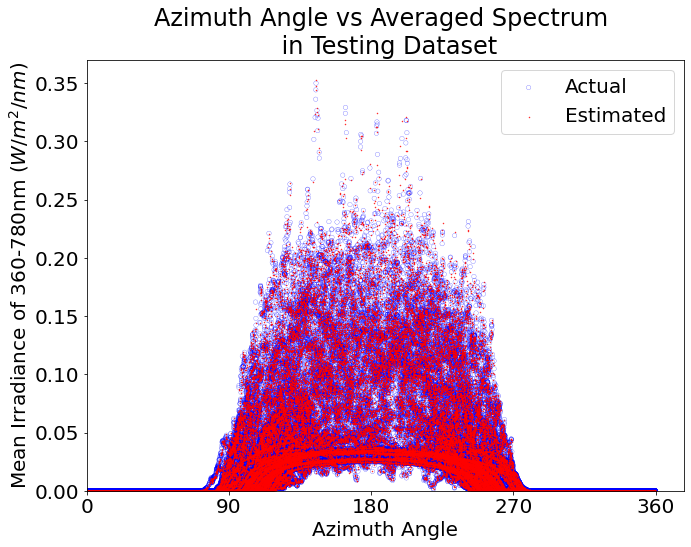

In [97]:
plt.rcParams["figure.figsize"] = (10, 8) # (w, h)
plt.rcParams.update({'font.size': 20})
colors = 'black' #pca.transform(scaler_x.transform(X))[:,0]

y_min = Y_test.mean(axis = 1).min()
y_max = Y_test.mean(axis = 1).max()
# Azimuth_min = Azimuth_test.min()

plt.scatter(Azimuth_test, Y_test.mean(axis = 1),
            marker = 'o', facecolors='none', edgecolors='blue', linewidths=0.2, s = 20,
            label = 'Actual')
plt.scatter(Azimuth_test, Y_test_pred.mean(axis = 1),
            marker = 'o', color = 'red', s = 0.2,
            label = 'Estimated')

plt.xticks(list(np.linspace(0,360,5)));
plt.xlabel('Azimuth Angle');
plt.ylabel('Mean Irradiance of 360-780nm $(W/m^2/nm)$');
plt.title('Azimuth Angle vs Averaged Spectrum \n in Testing Dataset')
plt.xlim(0,)
plt.ylim(0,)
plt.legend();
plt.tight_layout()
plt.savefig(dir_out + 'whole' + '/MLP_Azimuth_vs_Averaged_' + 'whole' + structure +'.png')


## Compare Actual Spectrum and Estimated Spectrum

In [98]:
X_test[X_test.index.date == datetime.date(2020, 3, 29)][:20]

,Violet,Blue,Green,Yellow,Orange,Red,IR,Visible,Lux,UVA,UVB,Visible Compensation,IR Compensation,UV Index
UTC,,,,,,,,,,,,,,
2020-03-29 03:18:10,0.0,0.0,0.0,0.0,0.0,0.0,2.0,11.0,0.506338,0.0,0.0,0.0,0.0,0.00
2020-03-29 12:27:40,47.0,64.0,57.0,57.0,40.0,48.0,6558.0,12638.0,452.631590,321.0,347.0,89.0,71.0,0.00
2020-03-29 11:53:00,0.0,0.0,0.0,0.0,0.0,0.0,28.0,46.0,1.555546,0.0,0.0,0.0,0.0,0.00
2020-03-29 11:39:30,0.0,0.0,0.0,0.0,0.0,0.0,3.0,12.0,0.522240,0.0,0.0,0.0,0.0,0.00
2020-03-29 19:58:00,1357.0,2007.0,2172.0,2321.0,1690.0,1761.0,65535.0,0.0,-1.000000,10940.0,11747.0,3334.0,2216.0,-0.24
2020-03-29 20:04:00,1353.0,1999.0,2167.0,2319.0,1687.0,1758.0,65535.0,0.0,-1.000000,10541.0,11306.0,3231.0,2146.0,-0.26
2020-03-29 18:08:40,1266.0,1851.0,1991.0,2117.0,1540.0,1596.0,65535.0,0.0,-1.000000,10620.0,11459.0,3267.0,2141.0,-0.25
2020-03-29 23:03:30,526.0,792.0,861.0,920.0,675.0,724.0,65535.0,0.0,-1.000000,4002.0,4314.0,1209.0,854.0,-0.10
2020-03-29 22:19:20,1063.0,1597.0,1733.0,1851.0,1353.0,1437.0,65535.0,0.0,-1.000000,8372.0,8971.0,2518.0,1712.0,-0.17


In [99]:
from wavelength_to_rgb import wavelength_to_rgb
clim=(350,780)
norm = plt.Normalize(*clim)
wl = np.arange(clim[0],clim[1]+1,2)
colorlist = list(zip(norm(wl),[wavelength_to_rgb(w) for w in wl]))
spectralmap = matplotlib.colors.LinearSegmentedColormap.from_list("spectrum", colorlist)

In [108]:
year1 = 2020
month1 = 3
day1 = 5
hour1 = 18
minute1 = 1
second1 = 30
lag = 6
date_string1 = '%04d-%02d-%02d %02d:%02d:%02d' % (year1, month1, day1, hour1, minute1, second1)
print(date_string1)

wavelengths = np.array(range(360,780+1))

iwant = (X_test.index== date_string1)
X1 = X_test_scaled_DR_scaled[iwant]
Y1 = Y_test[iwant].values
Y1_pred = scaler_y.inverse_transform(regr.predict(X1))

2020-03-05 18:01:30


In [109]:
year2 = 2020
month2 = 3
day2 = 29
hour2 = 18
minute2 = 8
second2 = 40
lag = 6
date_string2 = '%04d-%02d-%02d %02d:%02d:%02d' % (year2, month2, day2, hour2, minute2, second2)
print(date_string2)

wavelengths = np.array(range(360,780+1))

iwant = (X_test.index== date_string2)
X2 = X_test_scaled_DR_scaled[iwant]
Y2 = Y_test[iwant].values
Y2_pred = scaler_y.inverse_transform(regr.predict(X2))

2020-03-29 18:08:40


In [110]:
# actual
date_string = date_string1
spectrum = Y1[0]
Y_max = Y1[0].max()

fig, ax = plt.subplots(constrained_layout=True, figsize=(16, 8))
plt.rcParams.update({'font.size': 25})
h = ax.plot(wavelengths, spectrum)

plt.plot(wavelengths, spectrum)

y1 = np.linspace(0, Y_max*1.1, 100)

XX,YY = np.meshgrid(wavelengths, y1)
XX[XX<400] = 400
extent=(np.min(wavelengths), np.max(wavelengths), np.min(y1), np.max(y1))

plt.imshow(XX, clim=(350,780),  extent=extent, cmap=spectralmap, aspect='auto')
plt.fill_between(wavelengths, spectrum, Y_max*1.1, color='w')

ax.set_title('Actual Spectrum: '+ date_string.replace('-','/'))
ax.set_xlabel('Wavelength / nm')
ax.set_ylabel('Irradiance $(W/m^2/nm)$')

fig.savefig(dir_out+'Spectrum_' + date_string.replace('-','_').replace(' ','_').replace(':','_')+'.png')
plt.close()

In [111]:
# estimate
date_string = date_string1
spectrum = Y1_pred[0]
Y_max = Y1[0].max()

fig, ax = plt.subplots(constrained_layout=True, figsize=(16, 8))
plt.rcParams.update({'font.size': 25})
h = ax.plot(wavelengths, spectrum)

plt.plot(wavelengths, spectrum)

y1 = np.linspace(0, Y_max*1.1, 100)

XX,YY = np.meshgrid(wavelengths, y1)
XX[XX<400] = 400
extent=(np.min(wavelengths), np.max(wavelengths), np.min(y1), np.max(y1))

plt.imshow(XX, clim=(350,780),  extent=extent, cmap=spectralmap, aspect='auto')
plt.fill_between(wavelengths, spectrum, Y_max*1.1, color='w')
ax.set_title('Estimated Spectrum: '+ date_string.replace('-','/'))
ax.set_xlabel('Wavelength / nm')
ax.set_ylabel('Irradiance $(W/m^2/nm)$')

fig.savefig(dir_out+'Spectrum_' + date_string.replace('-','_').replace(' ','_').replace(':','_')+'_pred.png')
plt.close()

In [112]:
# actual
date_string = date_string2
spectrum = Y2[0]
Y_max = Y2[0].max()

fig, ax = plt.subplots(constrained_layout=True, figsize=(16, 8))
plt.rcParams.update({'font.size': 25})
h = ax.plot(wavelengths, spectrum)

plt.plot(wavelengths, spectrum)

y1 = np.linspace(0, Y_max*1.1, 100)

XX,YY = np.meshgrid(wavelengths, y1)
XX[XX<400] = 400
extent=(np.min(wavelengths), np.max(wavelengths), np.min(y1), np.max(y1))

plt.imshow(XX, clim=(350,780),  extent=extent, cmap=spectralmap, aspect='auto')
plt.fill_between(wavelengths, spectrum, Y_max*1.1, color='w')

ax.set_title('Actual Spectrum: '+ date_string.replace('-','/'))
ax.set_xlabel('Wavelength / nm')
ax.set_ylabel('Irradiance $(W/m^2/nm)$')

fig.savefig(dir_out+'Spectrum_' + date_string.replace('-','_').replace(' ','_').replace(':','_')+'.png')
plt.close()

In [113]:
# estimate
date_string = date_string2
spectrum = Y2_pred[0]
Y_max = Y2[0].max()

fig, ax = plt.subplots(constrained_layout=True, figsize=(16, 8))
plt.rcParams.update({'font.size': 25})
h = ax.plot(wavelengths, spectrum)

plt.plot(wavelengths, spectrum)

y1 = np.linspace(0, Y_max*1.1, 100)

XX,YY = np.meshgrid(wavelengths, y1)
XX[XX<400] = 400
extent=(np.min(wavelengths), np.max(wavelengths), np.min(y1), np.max(y1))

plt.imshow(XX, clim=(350,780),  extent=extent, cmap=spectralmap, aspect='auto')
plt.fill_between(wavelengths, spectrum, Y_max*1.1, color='w')
ax.set_title('Estimated Spectrum: '+ date_string.replace('-','/'))
ax.set_xlabel('Wavelength / nm')
ax.set_ylabel('Irradiance $(W/m^2/nm)$')

fig.savefig(dir_out+'Spectrum_' + date_string.replace('-','_').replace(' ','_').replace(':','_')+'_pred.png')
plt.close()

In [114]:
date_string1.replace('-','/')

'2020/03/05 18:01:30'

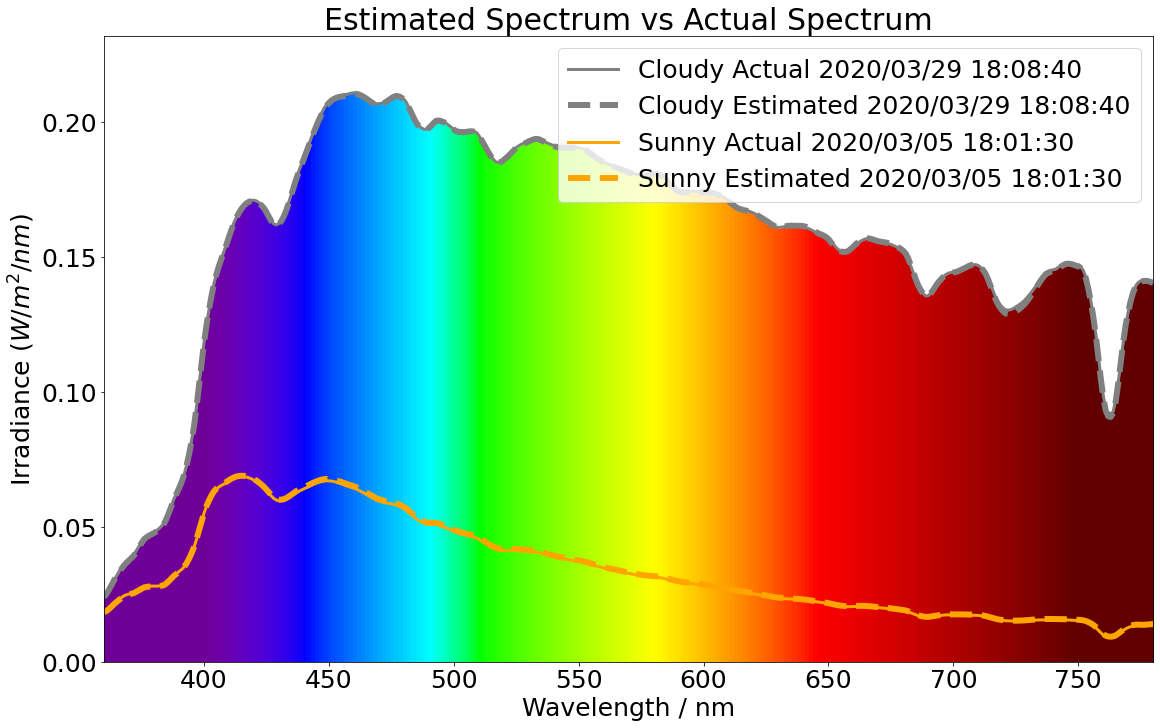

In [118]:
# compare
Y_max = max(Y1[0].max(), Y2[0].max())

fig, ax = plt.subplots(constrained_layout=True, figsize=(16, 10))
plt.rcParams.update({'font.size': 25})

## color
spectrum = Y2[0]
y1 = np.linspace(0, Y_max*1.1, 100)

XX,YY = np.meshgrid(wavelengths, y1)
XX[XX<400] = 400
extent=(np.min(wavelengths), np.max(wavelengths), np.min(y1), np.max(y1))

plt.imshow(XX, clim=(350,780),  extent=extent, cmap=spectralmap, aspect='auto')
plt.fill_between(wavelengths, spectrum, Y_max*1.1, color='w')



## compare
plt.plot(wavelengths, Y2[0], '-', color = 'gray', linewidth = 3, label = 'Cloudy Actual ' + date_string2.replace('-','/'))
plt.plot(wavelengths, Y2_pred[0], '--', color = 'gray', linewidth = 6, label = 'Cloudy Estimated ' + date_string2.replace('-','/'))

plt.plot(wavelengths, Y1[0], '-', color = 'orange', linewidth = 3, label = 'Sunny Actual ' + date_string1.replace('-','/'))
plt.plot(wavelengths, Y1_pred[0], '--', color = 'orange', linewidth = 6, label = 'Sunny Estimated ' + date_string1.replace('-','/'))

plt.xlim(360,780)
plt.ylim(0,Y_max*1.1)

ax.set_title('Estimated Spectrum vs Actual Spectrum')
ax.set_xlabel('Wavelength / nm')
ax.set_ylabel('Irradiance $(W/m^2/nm)$')

plt.legend( loc='upper right')

fig.savefig(dir_out+'Spectrum_'+ 
            date_string1.replace('-','_').replace(' ','_').replace(':','_') + '_' + 
            date_string2.replace('-','_').replace(' ','_').replace(':','_') +'.png' )
#plt.close()